<a href="https://colab.research.google.com/github/jheelamH/Annoying-submit-button/blob/main/INT_423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision matplotlib


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset (CIFAR-10 as an example dataset)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor()
])
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
# Define the VAE model for colorization
class ColorizationVAE(nn.Module):
    def __init__(self):
        super(ColorizationVAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # Output: 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # Output: 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # Output: 128x4x4
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(128 * 4 * 4, 256)
        self.fc_logvar = nn.Linear(128 * 4 * 4, 256)
        self.fc_decode = nn.Linear(256, 128 * 4 * 4)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # Output: 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # Output: 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, 4, stride=2, padding=1),    # Output: 2x32x32 (for AB channels)
            nn.Tanh()  # Output in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decoding
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.decoder(x)

        return x, mu, logvar


In [5]:
# Instantiate model, loss function, and optimizer
model = ColorizationVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence / x.size(0)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (grayscale, _) in enumerate(dataloader):
        grayscale = grayscale.to(device)

        # Forward pass
        ab_pred, mu, logvar = model(grayscale)

        # Compute loss
        loss = vae_loss(ab_pred, grayscale, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 32, 32])) that is different to the input size (torch.Size([64, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 32, 32])) that is different to the input size (torch.Size([16, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 0.0620
Epoch [2/20], Loss: 0.0573
Epoch [3/20], Loss: 0.0570
Epoch [4/20], Loss: 0.0569
Epoch [5/20], Loss: 0.0568
Epoch [6/20], Loss: 0.0567
Epoch [7/20], Loss: 0.0567
Epoch [8/20], Loss: 0.0567
Epoch [9/20], Loss: 0.0567
Epoch [10/20], Loss: 0.0566
Epoch [11/20], Loss: 0.0566
Epoch [12/20], Loss: 0.0566
Epoch [13/20], Loss: 0.0566
Epoch [14/20], Loss: 0.0566
Epoch [15/20], Loss: 0.0566
Epoch [16/20], Loss: 0.0566
Epoch [17/20], Loss: 0.0566
Epoch [18/20], Loss: 0.0566
Epoch [19/20], Loss: 0.0566
Epoch [20/20], Loss: 0.0566


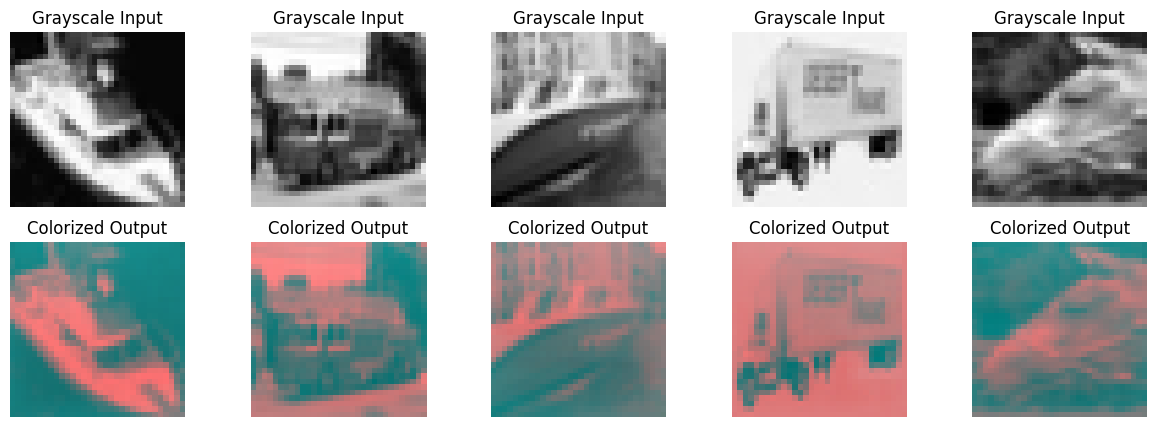

In [6]:
# Visualizing colorized images
def show_colorization_results(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        grayscale, _ = next(iter(dataloader))
        grayscale = grayscale[:num_images].to(device)

        # Generate color predictions
        ab_pred, _, _ = model(grayscale)

        # Prepare images for visualization
        fig, axs = plt.subplots(2, num_images, figsize=(15, 5))
        for i in range(num_images):
            # Display grayscale input
            axs[0, i].imshow(grayscale[i].squeeze().cpu(), cmap='gray')
            axs[0, i].axis('off')
            axs[0, i].set_title("Grayscale Input")

            # Display colorized output
            colorized = torch.cat([grayscale[i], ab_pred[i]], dim=0)
            colorized = colorized.permute(1, 2, 0).cpu().numpy()
            axs[1, i].imshow(colorized)
            axs[1, i].axis('off')
            axs[1, i].set_title("Colorized Output")
        plt.show()

show_colorization_results(model, dataloader)
